## **Using Decision Trees to Classify Galaxies - Arash Nourimand**

Data derived from the Galaxy Zoo Citizen Science Galactic Classification project, from galaxies observed in the Sloan digital sky survey - data of galaxies with 80% agreement on classification is selected (link: https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/classify). (inspired by Data Driven Astronomy by the University of Sydney)


**Quick Notes**

*Classification* = predictions are from a fixed set of classes

*Regression* = prediction  corresponds to a continuum of possible values 

*Decision tree regression* = possible outputs are a finite set of values that correspond to the number of leaves/end points in the tree (i.e. more end points gives a good approximation of the continuum)


## **Dataset feature classification for the model:**


*   *Eccentricity of the galaxy* ![](https://groklearning-cdn.com/modules/ZBL7wT9VqgcJZUBe2WDqva/eccentricity_example.png)
*   *Colour indices* - are the same colours (u-g, g-r, r-i, and i-z) captured by the sloan digital sky survey (spiral galaxies have younger star populations/more blue and Elliptical galaxies have an older/more red) ![](https://groklearning-cdn.com/modules/y8uy8PqJcjpPE47SKB3pPA/sdss_filters.png)
*   *Adaptive moments* - describe the shape of a galaxy (use the fourth moment here for each band)
*   *Concentration* - is similar to the luminosity profile of the galaxy, which measures what proportion of a galaxy's total light is emitted within what radius. A simplified way to represent this is to take the ratio of the radii containing 50% and 90% of the Petrosian flux. ![](https://groklearning-cdn.com/modules/UAAhKfyAhDnQWiVUP5NMi6/concentration_example.png)






In [0]:
#load the data
import numpy as np
data_file_path = '/content/drive/My Drive/Colab Notebooks/galaxy_catalogue.npy'
data = np.load(data_file_path)

In [0]:
#make a function to split the data by train/test
def splitdata_train_test(data, fraction_training):
  # first thing to do is to randomize the dataset order
  np.random.seed(0)
  np.random.shuffle(data)
  #define the index to split the data and then make the train/test subsets
  
  split_index = int(round(fraction_training*len(data),0))
  train = data[:split_index]
  test = data[split_index:]
  return (train, test)

#run the function above
fraction_training = 0.7 # fraction of data which should be in the training set
training, testing = splitdata_train_test(data, fraction_training)

#show the key values
print('Number data galaxies:', len(data))
print('Train fraction:', fraction_training)
print('Number of galaxies in training set:', len(training))
print('Number of galaxies in testing set:', len(testing))

Number data galaxies: 780
Train fraction: 0.7
Number of galaxies in training set: 546
Number of galaxies in testing set: 234


In [0]:
#make a function to define the features used for the model

def generate_features_targets(data):
  targets = data['class'] #target is the galaxy class
  features = np.empty(shape=(len(data), 13)) #make an empty numpy array to store the needed feature data

  #extract the features from the data and add to the feature array (color channels, eccentricity, adaptive moments, concentrations)
  features[:, 0] = data['u-g']
  features[:, 1] = data['g-r']
  features[:, 2] = data['r-i']
  features[:, 3] = data['i-z']
  features[:, 4] = data['ecc']
  features[:, 5] = data['m4_u']
  features[:, 6] = data['m4_g']
  features[:, 7] = data['m4_r']
  features[:, 8] = data['m4_i']
  features[:, 9] = data['m4_z']
  features[:, 10] = data['petroR50_u']/data['petroR90_u']
  features[:, 11] = data['petroR50_r']/data['petroR90_r']
  features[:, 12] = data['petroR50_z']/data['petroR90_z']

  return features, targets

#run and show the values of the features and the targets
features, targets = generate_features_targets(data)
print("Features shape:", features.shape)
print("Targets shape:", targets.shape)

Features shape: (780, 13)
Targets shape: (780,)


In [0]:
#start by training a standard decision tree classifier
from sklearn.tree import DecisionTreeClassifier

#make a function to declare a model and then train and then predict from the data - useful if other models are to be tested
def predict_actual(model, data):
  # split the data into training and testing sets using a training fraction of 0.7
  train, test = splitdata_train_test(data, fraction_training = 0.7)
  
  # generate the feature and targets for the training and test sets
  train_features, train_targets = generate_features_targets(train)
  test_features, test_targets = generate_features_targets(test)
  
  # train the classifier with the train_features and train_targets and get the predictions for the test features
  model.fit(train_features, train_targets)
  predictions = model.predict(test_features)
  
  return (predictions, test_targets) # return the predictions and the test_targets

# Function to check accuracy
def calculate_accuracy(predicted, actual):
  n = len(predicted)
  correct = 0
  for i in range(n):
    if predicted[i] == actual[i]:
      correct = correct+1
  return (correct/n)    

#run the model and generate the score
model = DecisionTreeClassifier()
pred, actual = predict_actual(model, data)
model_score = calculate_accuracy(pred, actual)
print("Accuracy score:", model_score)
print("\nInitial results:\n   predicted,  actual")
for i in range(10):
  print("{}. {}, {}".format(i, pred[i], actual[i]))

Accuracy score: 0.7905982905982906

Initial results:
   predicted,  actual
0. spiral, spiral
1. spiral, merger
2. merger, merger
3. merger, merger
4. spiral, spiral
5. elliptical, elliptical
6. merger, merger
7. merger, merger
8. spiral, spiral
9. elliptical, merger


In [0]:
#improve the existing model by implementing kfold cross validation
from sklearn.model_selection import cross_val_predict

modelx = DecisionTreeClassifier()
features, targets = generate_features_targets(data)
pred2 = cross_val_predict(model, features, targets, cv=10) #perform the same prediction using 10 folds in cross validation

model_score2 = calculate_accuracy(pred2, targets)
print("Accuracy score:", model_score2)

Accuracy score: 0.8128205128205128


Confusion matrix, without normalization
[[203  55   2]
 [ 48 192  20]
 [  3  18 239]]


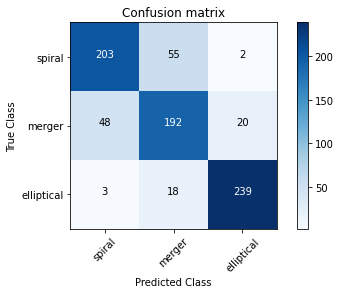

In [0]:
import itertools
from matplotlib import pyplot as plt

#confusion matrix code derived from scikit learn site
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

  
# calculate the models confusion matrix using sklearns confusion_matrix function
class_labels = list(set(targets))
model_cm = confusion_matrix(y_true=targets, y_pred=pred2, labels=class_labels)

# Plot the confusion matrix using the provided functions.
plt.figure()
plot_confusion_matrix(model_cm, classes=class_labels, normalize=False)
plt.show()

CV Accuracy score: 0.8653846153846154
Generic Accuracy score: 0.8974358974358975
Confusion matrix, without normalization
[[24 28 27]
 [23 21 27]
 [30 24 30]]


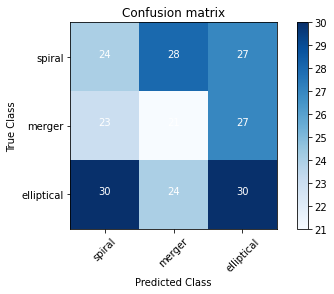

In [0]:
#Attempt a random forest which is an ensemble method of a variety of trees wherein the output is the majority classification
from sklearn.ensemble import RandomForestClassifier

rfcv = RandomForestClassifier(n_estimators = 50) #nestimators is the number of trees
features, targets = generate_features_targets(data)
predictions = cross_val_predict(rfcv, features, targets, cv=3)

#test cross validated accuracy
accuracy = calculate_accuracy(predictions, targets)
print("CV Accuracy score:", accuracy)

# get the predicted and actual classes
predrf, actual = predict_actual(rf, data)

# calculate the model score using your function
accuracyrf = calculate_accuracy(predrf, actual)
print("Generic Accuracy score:", accuracyrf)

# calculate the models confusion matrix using sklearns confusion_matrix function
class_labels = list(set(actual))
model_cm = confusion_matrix(y_true=actual, y_pred=pred3, labels=class_labels)

# plot the confusion matrix using the provided functions.
plt.figure()
plot_confusion_matrix(model_cm, classes=class_labels, normalize=False)
plt.show()